# Tobit

In [1]:
import numpy as np
import pandas as pd 
from numpy import linalg as la
from scipy.stats import norm
from scipy import optimize
from tabulate import tabulate
from matplotlib import pyplot as plt
import seaborn as sns 
sns.set_theme()

%load_ext autoreload
%autoreload 2

import tobit
import estimation
import LinearModels as lm

# Simulate Data

1. Fill out `tobit.sim_data(theta,N)` and simulate a dataset
2. Fill out `tobit.predict(theta, x)`, returning `E, Epos`: 
$$
\begin{align}
\mathbb{E}(y_{i}|\mathbf{x}_{i})	&=	\mathbf{x}_{i}\beta\Phi\left(\frac{\mathbf{x}_{i}\beta}{\sigma}\right)+\sigma\phi\left(\frac{\mathbf{x}_{i}\beta}{\sigma}\right),
\\
\mathbb{E}(y_{i}|\mathbf{x}_{i},y_{i}>0)	&=	\mathbf{x}_{i}\beta+\sigma\lambda\left(\frac{\mathbf{x}_{i}\beta}{\sigma}\right).
\end{align}
$$

In [2]:
N = 1000
betao = np.array([1.,1.])
sigo = 1.
thetao = np.append(betao, sigo) # since sigo is scalar, use np.append() rather than np.stack

In [3]:
np.random.seed(1)
y,x = tobit.sim_data(thetao, N)

In [4]:
E, Epos = tobit.predict(thetao, x)

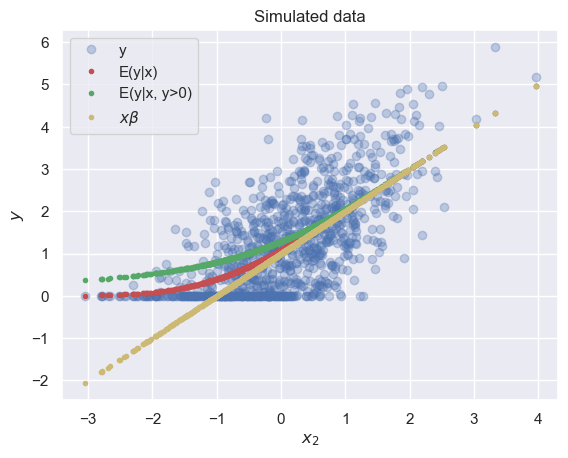

In [5]:
fig,ax = plt.subplots();
ax.plot(x[:, 1], y, 'o', alpha=0.3, label='y');
ax.plot(x[:, 1], E,    '.r', label='E(y|x)')
ax.plot(x[:, 1], Epos, '.g', label='E(y|x, y>0)')
ax.plot(x[:, 1], x@betao,  '.y', label='$x \\beta$')
ax.set_title('Simulated data'); ax.set_xlabel('$x_2$'); ax.set_ylabel('$y$');
ax.legend();

## Question 2:

1. Fill out `tobit.starting_values(y,x)`: base starting values of $\boldsymbol{\theta} = (\boldsymbol{\beta}, \sigma)$ on OLS counterparts; even though they are inconsistent, they are somewhat in the ballpark. Note that we will be estimating $\sigma$ and not $\sigma^2$.  
2. Finish writing the criterion function, `q(theta, y, x)` based on `loglikelihood(theta, y, x)`, in the `tobit.py` based on the likelihood function $$ 
\ell_i(\theta) = \mathbf{1}\{y_i = 0\} \log\left[1 - \Phi\left(\frac{\mathbf{x}_i \boldsymbol{\beta}}{\sigma}\right)\right] 
               + \mathbf{1}\{y_i > 0\} \log\left[\frac{1}{\sigma} \phi\left(\frac{y_i - \mathbf{x}_i \boldsymbol{\beta}}{\sigma}\right)\right] $$
3. Estimate the model on simulated data

***Hints:***
* For the normal CDF and PDF: Use `norm.cdf` and `norm.cdf` from `scipy.stats`
* Since you are taking logs, it can be good practice to ensure that you are not taking log of zero. Use `np.clip(vec, 1e-8, 1.0-1e-8)`, for example, to ensure that `vec` is within $[0.00000001; 0.99999999]$
* Force `sigma` to remain positive during estimation by taking `np.abs(sigma)` when unpacking parameters (in `loglikelihood`, e.g.)

You can check if you got the correct result below.

In [6]:
theta0 = tobit.starting_values(y, x)
theta0

array([1.22225581, 0.78971417, 0.87827126])

In [7]:
# call the loglikelihood function 
ll0 = tobit.loglikelihood(theta0, y, x)

# this can sometimes be off if your seed is not set or if your version is very different from 
# the one used by me (np.__version__ = 1.21.2)
np.isclose( np.mean(ll0), -1.3433337203403535 ) 

True

In [8]:
res = estimation.estimate(tobit.q, theta0, y, x, cov_type='Sandwich')

Optimization terminated successfully.
         Current function value: 1.288781
         Iterations: 7
         Function evaluations: 32
         Gradient evaluations: 8


Print results out in a neat table 

In [9]:
result_dict = {'theta_o': thetao, 
              'thetahat': res['theta'], 
              't': res['t']}
lab_theta = ['x1', 'x2', 'sigma']

pd.DataFrame(result_dict, index=lab_theta).round(3)

,theta_o,thetahat,t
x1,1.0,1.022,30.107
x2,1.0,1.035,28.312
sigma,1.0,1.029,42.136


Expected results: Final function value: 1.288781, Function evaluations: 32. 

|       |   theta_o |   thetahat |      t |
|:------|----------:|-----------:|-------:|
| x1    |         1 |      1.022 | 30.107 |
| x2    |         1 |      1.035 | 28.312 |
| sigma |         1 |      1.029 | 42.137 |

Empirical analysis
==================

The exercise asks you to estimate a censored regression model for the
number of working hours in the labour market, using the `mroz_hours.txt`
dataset (same as PS04, with working hours). Working hours is a
left-censored variable because the variable hours takes the value zero
when no hours are put in the labour market. The data set
`mroz_hours.txt` contains observations on 753 women for the following
variables:

|*Variable*  | *Definition*|
|------------| ---------------------------------|
|`Hours`     | Number of hours worked annually|
|`Nwifeinc`  | Non wife income|
|`Educ`      | Years of education|
|`Exper`     | Experience in labour market|
|`Expersq`   | Experience squared|
|`Age`       | Age|
|`Kidslt6`   | Number of kids aged 0--5|
|`Kidsge6`   | Number of kids aged 6--18|

In [10]:
# some of the columns are not documented; we name them n.a. X
cols = ['hours', 'n.a. 1', 'nwifeinc', 'exper', 'expersq', 'age', 'kidslt6', 'kidsge6', 
        'n.a. 2', 'n.a. 3', 'n.a. 4', 'educ']

# read dataset 
dat = pd.read_csv('mroz_hours.txt', header = None, names = cols)

# add constant term 
dat['cnst'] = 1.0

# Declare labels
lbly = 'hours'
lblx = ['cnst', 'nwifeinc', 'educ', 'exper', 'expersq', 'age', 'kidslt6', 'kidsge6']

# pandas to numpy 
x = dat[lblx].values
y = dat[lbly].values

## Question 3
As a preperation, plot y in a histogram. Does the distribution of hours worked look probelmatic?

In [11]:
# The matbplotlib.pyplot module is already loaded for you as plt.
# A hint is to use more bins than default, try for example 50 bins.
# FILL IN: Plot a histogram of y.

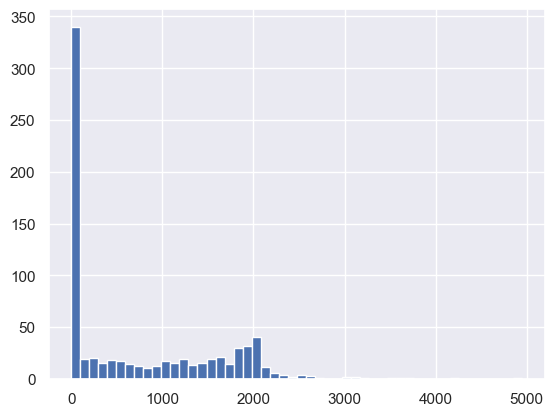

In [12]:
plt.hist(y, 50) ;

## Question 1:
Estimate by OLS a regression function of annual hours worked as a function of the variables (`cnst`, `nwifeinc, educ, exper, expersq, age, kidslt6, kidsge6`), using the `LinearModels` module. 

You then have to create a numpy array called `theta0` with shape `(9,)`: The first $K=8$ parameters are $\boldsymbol{\beta}$, and the last, 9th coefficient is $\sigma$ (and not $\sigma^2$!). 

In [13]:
# FILL IN: Estimate the model of y on x using OLS
# FILL IN: Print the results in a nice table
# FILL IN: Print the results in a nice table

# FILL IN: Create a theta0 array with (9, 1) dimensions
# FILL IN: Fill the first 8 rows with b_hat from the OLS regression
# FILL IN: Fill the last row with sigma2 from the OLS regression

In [14]:
N,K = x.shape
b = np.linalg.solve(x.T@x, x.T@y)
u = y - x@b
sig = np.dot(u,u)/(N-K)
theta0 = np.append(b, np.sqrt(sig))

In [15]:
ols_results = lm.estimate(y, x)

In [16]:
d = {'betahat': ols_results['b_hat'],
     'se': ols_results['se'].flatten()}
tab = pd.DataFrame(d, index=lblx)
pd.concat((tab,pd.DataFrame({'betahat': sig, 'se': np.nan}, index=['sigma'])))

,betahat,se
cnst,1330.482400,273.413494
nwifeinc,-3.446636,2.228727
educ,28.761125,12.969602
exper,65.672513,10.736696
expersq,-0.700494,0.370031
age,-30.511634,4.222182
kidslt6,-442.089908,57.157767
kidsge6,-32.779226,22.680931
sigma,562767.943515,NaN


In [17]:
ols_results = lm.estimate(y.reshape(-1,1), x)
lm.print_table((lbly, lblx), ols_results)

theta0 = tobit.starting_values(y,x)

Results
Dependent variable: hours

                 Beta          Se    t-values
--------  -----------  ----------  ----------
cnst      1330.48      273.413        4.86619
nwifeinc    -3.44664     2.22873     -1.54646
educ        28.7611     12.9696       2.21758
exper       65.6725     10.7367       6.11664
expersq     -0.700494    0.370031    -1.89307
age        -30.5116      4.22218     -7.22651
kidslt6   -442.09       57.1578      -7.73456
kidsge6    -32.7792     22.6809      -1.44523
R² = 0.266
σ² = 562767.944


## Question 2:
1. Finish writing the criterion function, in the `toibt.py` based on the likelihood function $$ 
\ell_i(\theta) = \mathbf{1}\{y_i = 0\} \log\left[1 - \Phi\left(\frac{\mathbf{x}_i \boldsymbol{\beta}}{\sigma}\right)\right] 
               + \mathbf{1}\{y_i > 0\} \log\left[\frac{1}{\sigma} \phi\left(\frac{y_i - \mathbf{x}_i \boldsymbol{\beta}}{\sigma}\right)\right] $$
2. Estimate the model 

***Hints:***
* For the normal CDF and PDF: Use `norm.cdf` and `norm.cdf` from `scipy.stats`
* Since you are taking logs, it can be good practice to ensure that you are not taking log of zero. Use `np.clip(vec, 1e-8, 1.0-1e-8)`, for example, to ensure that `vec` is within $[0.00000001; 0.99999999]$
* Force `sigma` to remain positive during estimation by taking `np.abs(sigma)` when unpacking parameters. 

You can check if you got the correct result below.

In [18]:
np.isclose(
    np.mean(tobit.loglikelihood(theta0, y, x))
    , -5.257462977706353
)

True

## Question 3:
Estimate the corresponding Censored Regression Model by Maximum Likelihood. To do this, $\texttt{[FILL IN]}$ the blanks in the $\texttt{criterion}$ function in the $\texttt{tobit}$ class and supply it to the $\texttt{estimation\_m}$ function exactly as you did with the linear equation last week. Report also $\hat{\sigma}^{2}$ and $R_{\mathrm{Tobit}}^{2}$. 

In [19]:
result = estimation.estimate(tobit.q, theta0, y, x)

Optimization terminated successfully.
         Current function value: 5.072230
         Iterations: 124
         Function evaluations: 1300
         Gradient evaluations: 130


## Question 4
Calculate the $R_{\mathrm{Tobit}}^{2}$, this is the squared correlation between $y_{i}$ and $\hat{y}_{i}$, where $\hat{y}_i = \Phi (\mathbf{x}_i \hat{\beta}/\hat{\sigma})\mathbf{x}_i \hat{\beta} + \hat{\sigma}\phi(\mathbf{x}_i \hat{\beta}/\hat{\sigma})$, which is the estimate of $\mathrm{E}\left(y|\mathbf{x}=\mathbf{x}_{i}\right )$\] ($\Phi$ is the normal cdf, and $\phi$ is the normal pdf).

In [20]:
# Compute R2
sigma_tob = result.get('theta')[-1]
sig_tob   = result.get('theta')[-1]
b_tob     = result.get('theta')[:-1]
b_se_tob  = result.get('se')[:-1]

xb = x@b_tob
y_hat = xb*norm.cdf(xb/sigma_tob) + sigma_tob*norm.pdf(xb/sigma_tob)
rho = np.corrcoef(y.flatten(), y_hat.flatten())[0, 1]
R2_tob = rho*rho

In [21]:
tab = pd.DataFrame({'b_ols': theta0[:-1], 'b_tobit': b_tob, 'se': b_se_tob}, index=lblx)
tab = pd.concat((tab,pd.DataFrame({'b_ols': theta0[-1], 'b_tobit': sig_tob, 'se': result['se'][-1]}, index=['sigma'])))
tab = pd.concat((tab,pd.DataFrame({'b_ols': '', 'b_tobit': '', 'se': R2_tob}, index=['R2'])))

tab.round(3)

,b_ols,b_tobit,se
cnst,1330.4824,1272.979094,452.357
nwifeinc,-3.446636,-8.596165,4.427
educ,28.761125,73.35293,21.802
exper,65.672513,129.909733,16.321
expersq,-0.700494,-1.796722,0.508
age,-30.511634,-58.850776,7.895
kidslt6,-442.089908,-951.04873,113.089
kidsge6,-32.779226,-27.985774,38.991
sigma,750.178608,1126.114758,42.132
R2,,,0.275


Your table should look something like this:

Tobit Results <br>
Dependent variable: hours <br>


|          | b_ols   | b_tobit   |      se |
|:---------|:--------|:----------|--------:|
| cnst     | 1330.48 | 1272.98   | 452.357  |
| nwifeinc | -3.45   | -8.596     |   4.427  |
| educ     | 28.76   | 73.35     |  21.802  |
| exper    | 65.67   | 129.9097    |  16.321  |
| expersq  | -0.7    | -1.7967     |   0.508  |
| age      | -30.51  | -58.85    |   7.895  |
| kidslt6  | -442.09 | -951.048   | 113.089  |
| kidsge6  | -32.78  | -27.986    |  38.991  |
| sigma    | 750.18  | 1126.115   |  41.132  |
| R2       |         |           |   0.275 |

## Question 4: 
Calculate the two types of marginal effects, cf. eqs. (7) and (9), of taking an additional year of education evaluated at the mean values of the $\mathbf{x}$'s. Remember that $\lambda(\mathbf{x}\mathbf{\beta}/\sigma) \equiv \phi \left( \mathbf{x}\mathbf{\beta}/\sigma
\right) / \Phi \left( \mathbf{x}\mathbf{\beta}/\sigma \right)$ is called the inverse Mills ratio.
$$
\begin{align}
\frac{\partial \mathrm{E}\left( y|\mathbf{x},y>0\right) }{\partial x} 
&=\beta\Big( 1 - \lambda(\cdot) \big[ 
        \mathbf{x}\mathbf{\beta} / \sigma +\lambda(\cdot)
    \big] \Big). \tag{7} 
\end{align}
$$

$$
\begin{align}
\frac{\partial \mathrm{E}\left( y|\mathbf{x}\right) }{\partial x}
&= \beta \Phi\left(\frac{\mathbf{x}\mathbf{\beta}}{\sigma }\right), \tag{9}
\end{align}
$$

***Hints:***
* Note that `lambda` is a keyword in Python (used when defining an anonymous function) so you cannot create a variable by that name.
* For both marginal effects, the expression ends up being $\boldsymbol{\beta}$ ($K \times 1$) times something that is scalar (when evaluated at some $\mathbf{x} = \mathbf{x}^0$). However, later we may want to give as an input the full `x` matrix ($N \times K$), whereby the scalar becomes `(N,)` instead. Use `np.outer(beta, stuff)` to return an appropriate matrix in that case (it also works if `stuff` is scalar).


In [22]:
thetahat = result.get('theta')
b_tob = thetahat[:-1]
sigma_tob = thetahat[-1]

In [23]:
x0 = np.mean(x, axis=0)
x0[4] = x0[3]*x0[3]  # Square of mean, and not mean of square.

In [24]:
# I recommend that you make a function out of this, which takes x an b as an input, which are the representative observation and the b_hat coefficients (from the tobit estimatino) respectively. I have already created the bones of a function for you.

def marg_effect(x, b):  
    # FILL IN: Calculate first the inverse Mills ratio.
    # Write up the marginal effect using eq. (7). Note that the square bracket gives you a single value, which you multiply on the beta vector. Call this margeff_1

    # Write up the marginal effect using eq. (9). Again, you multiply the beta vector on a single value. Call this margeff_2

    return margeff_1, margeff_2

In [25]:
def mills_ratio(z):
    return norm.pdf(z) / norm.cdf(z)

def marg_effect(x, b_tob, sigma_tob):
    xb = x@b_tob
    phi = norm.cdf(xb/sigma_tob)
    
    h = 1e-8
    phi = np.clip(phi, h, 1-h)

    # dE(y|x,y>0)/dx, see eq.(7)
    lam = mills_ratio(xb/sigma_tob)  # Inverse Mills ratio
    factor = 1 - lam*(xb/sigma_tob + lam)  # the square bracket
    margeff_1 = np.outer(b_tob, factor)  # eq. (y)

    # dE(y|x)/dx, see eq.(9)
    margeff_2 = np.outer(b_tob, phi)

    return margeff_1, margeff_2

In [26]:
# Calculate the marginal effect and print out the effect of education.
margeff_1, margeff_2 = marg_effect(x0, b_tob, sigma_tob)
table = [
    ['dE(y|x,y>0)/dx', margeff_1[2]], 
    ['dE(y|x)/dx', margeff_2[2]]
]
print('Marginal effect of an additional year of education from tobit model')
print(tabulate(table))

Marginal effect of an additional year of education from tobit model
--------------  -------
dE(y|x,y>0)/dx  33.0551
dE(y|x)/dx      47.1457
--------------  -------


## Question 5:
Calculate for all individuals the two types of marginal effects of taking an additional year of education. i) Draw a histogram of the marginal effect of education across individuals. ii) Make a scatter plot with educ along the x-axis and the marginal effect along the y-axis. Give an interpretation of your findings.

In [27]:
# If you have written the function correctly, we should be able to pass the whole x matrix thorugh the function.
margeff_all_1, margeff_all_2 = marg_effect(x, b_tob, sigma_tob)

In [28]:
me1 = pd.DataFrame(margeff_all_1.T, columns=lblx)
me2 = pd.DataFrame(margeff_all_2.T, columns=lblx)

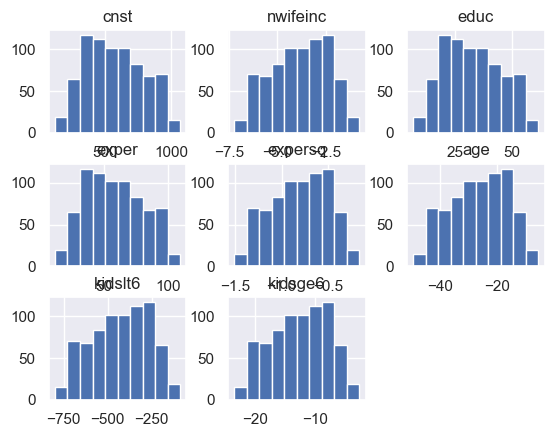

In [29]:
me1.hist();

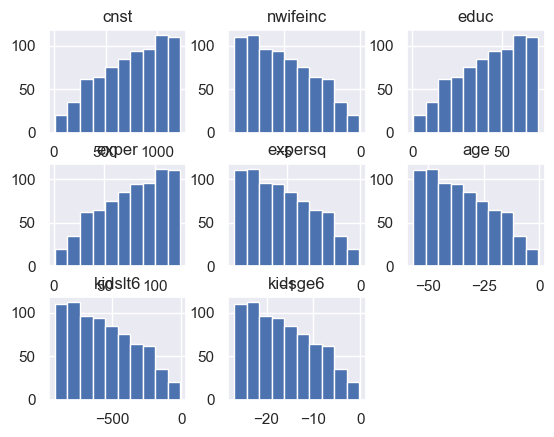

In [30]:
me2.hist();

In [31]:
# FILL IN: Plot a histogram of the marginal effect from one additional year of aducation from margeff_all_1
# FILL IN: Plot a histogram of the marginal effect from one additional year of aducation from margeff_all_2

# FILL IN: Plot a scatterplot of the marginal effect from one additional year of aducation from margeff_all_1
# FILL IN: Plot a scatterplot of the marginal effect from one additional year of aducation from margeff_all_2

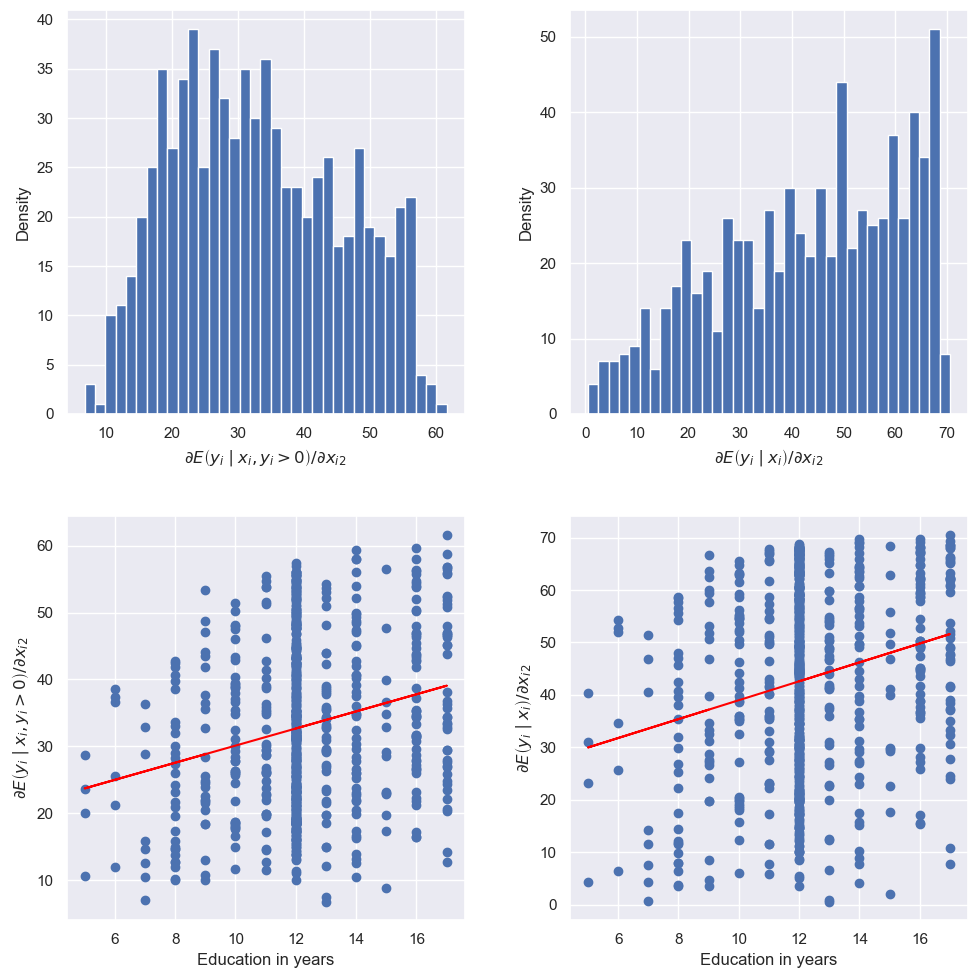

In [32]:
fig = plt.figure(figsize=(10, 10))
# Set global font size parameter.
plt.rcParams['font.size'] = '14'

# Histogram 1
ax1 = fig.add_subplot(2, 2, 1)
ax1.hist(
    margeff_all_1[2], 
    bins=35)
ax1.set_ylabel('Density')
ax1.set_xlabel(
    r"$\partial E\left(y_{i}\mid x_{i},y_{i}>0\right)/\partial x_{i2}$"
)

# Histogram 2
ax2 = fig.add_subplot(2, 2, 2)
ax2.hist(
    margeff_all_2[2], 
    bins=35)
ax2.set_ylabel('Density')
ax2.set_xlabel(
    r"$\partial E\left(y_{i}\mid x_{i}\right)/\partial x_{i2}$"
)

# Scatter 1
ax3 = fig.add_subplot(2, 2, 3)
ax3.scatter(x[:, 2], margeff_all_1[2])
# Plot line of best fit:
b, a = np.polyfit(x[:, 2], margeff_all_1[2], 1)
ax3.plot(x[:, 2], a + b*x[:, 2], color='red')
ax3.set_ylabel(
    r"$\partial E\left(y_{i}\mid x_{i},y_{i}>0\right)/\partial x_{i2}$"
)
ax3.set_xlabel('Education in years')

# Scatter 2
ax4 = fig.add_subplot(2, 2, 4)
ax4.scatter(x[:, 2], margeff_all_2[2])
# Plot line of best fit:
b, a = np.polyfit(x[:, 2], margeff_all_2[2], 1)
ax4.plot(x[:, 2], a + b*x[:, 2], color='red')
ax4.set_ylabel(
    r"$\partial E\left(y_{i}\mid x_{i}\right)/\partial x_{i2}$"
)
ax4.set_xlabel('Education in years')

# Make some space between subplots and make it nice.
fig.tight_layout(h_pad=2.5, w_pad=2.5)
plt.show()

# Covid example

In the following, let's switch gears and have a look at some Covid data and estimate the Tobit model there. The overarching question is: What is the effect of temperature on disease burden? Specifically, let us focus on deaths, since it does not confound testing intensity or other measures that may be different across countries. 

In [33]:
dat = pd.read_csv('covid.csv')
dat['date'] = pd.to_datetime(dat['date'])

# vaccinations are coded as missings before vaccination data collection began 
dat.people_fully_vaccinated_per_hundred = dat.people_fully_vaccinated_per_hundred.fillna(0.0)

## Descriptive

In [34]:
my_fav_country = 'Denmark' # <- change this around

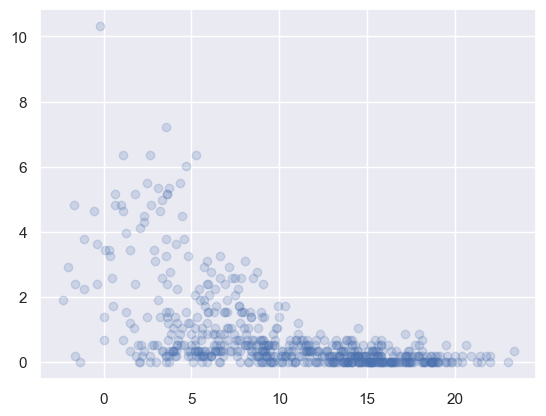

In [35]:
I = (dat.country == my_fav_country) & (dat.new_deaths_per_million >= 0.0)
plt.plot(dat[I].temperature, dat[I].new_deaths_per_million, 'o', alpha=0.2); 

## Tobit

In [36]:
yvar = 'new_deaths_per_million'
dat['const'] = 1.0 
xvars = ['const', 'temperature', 'stringency_index', 'people_fully_vaccinated_per_hundred', 'location_workplaces', 'mobility_driving']
I = (dat.country == 'Denmark') & (dat[yvar] >= 0.0) & (dat[xvars + [yvar]].notnull().all(axis=1))
y = dat.loc[I, 'new_deaths_per_million'].values
x = dat.loc[I, xvars].values

In [37]:
theta0 = tobit.starting_values(y, x)

res = estimation.estimate(tobit.q, theta0, y, x, cov_type='Outer Product', method='Nelder-Mead')

pd.DataFrame({'ols': theta0, 'theta': res['theta'], 't': res['t']}, index=xvars + ['sigma'])

Optimization terminated successfully.
         Current function value: 1.290340
         Iterations: 555
         Function evaluations: 834


,ols,theta,t
const,3.176824,4.622764,6.854191
temperature,-0.042279,-0.065919,-3.806097
stringency_index,-0.002188,-0.011334,-1.390232
people_fully_vaccinated_per_hundred,0.003107,0.006079,1.379641
location_workplaces,-0.013439,-0.014540,-4.915879
mobility_driving,-0.016825,-0.025332,-8.579016
sigma,0.989510,1.160562,48.846765


In [38]:
E,E_pos = tobit.predict(res['theta'], x)

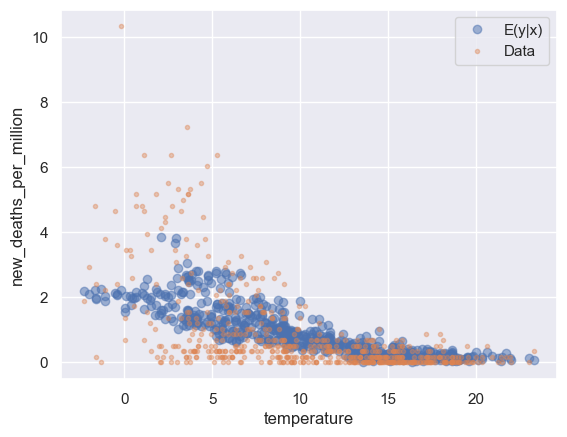

In [39]:
k = [i for i,xv in enumerate(xvars) if xv == 'temperature'][0]
fig,ax = plt.subplots(); 
ax.plot(x[:, k], E, 'o', label='E(y|x)', alpha=0.5); 
ax.plot(x[:, k], y, '.', label='Data', alpha=0.4); 
ax.set_xlabel(xvars[k]); ax.set_ylabel(yvar); 
ax.legend(); 